# Extra Metrics

Gorodetskaya et al. (2021) resalta la importancia de rolling mean

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [13]:
data = pd.read_csv('../data/aggregated_data_extra_metrics.csv')

In [17]:
data.head()

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Type,Weekday,Holiday Sequence,isYesterdayHoliday,isHoliday,isTomorrowHoliday,isYesterdayWeekday,isTomorrowWeekday,isWeekday,isPaymentDay,isPayweek,rolling_mean_weekday,rolling_max,lag_6,rolling_max_weekday,rolling_std,rolling_mean
0,Big Street ATM,2020-01-01,125,26,99,429200,75500,353700,National holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,429200.0,429200,429200.0,429200.0,110305.974453,2.988000e+05
1,Mount Road ATM,2020-01-01,144,49,95,377900,155200,222700,National holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,377900.0,983100,377900.0,377900.0,220819.202064,4.999467e+05
2,Airport ATM,2020-01-01,78,58,20,315400,269100,46300,National holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,315400.0,1034000,315400.0,315400.0,272711.985435,5.019806e+05
3,KK Nagar ATM,2020-01-01,268,176,92,1290200,927700,362500,National holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,1290200.0,1710500,1290200.0,1290200.0,289313.606662,1.059403e+06
4,Christ College ATM,2020-01-01,95,39,56,427100,235700,191400,National holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,427100.0,748100,427100.0,427100.0,146317.422066,4.707613e+05


## RIDGE - LASSO - ELASTICNET (OPTUNA)

In [38]:
# Let's start by removing the 'Type' column and preparing for target encoding of the 'Weekday' and 'Holiday Sequence' columns
# We will also analyze how to handle 'ATM Name'

# Drop the 'Type' column
data_cleaned = data.drop(columns=['Type', 'No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals', 'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card'])

# Display unique values in 'Weekday' and 'Holiday Sequence' to understand them before target encoding
weekday_unique = data_cleaned['Weekday'].unique()
holiday_sequence_unique = data_cleaned['Holiday Sequence'].unique()

# Show the shape of the dataset and the unique values in 'Weekday' and 'Holiday Sequence'
data_cleaned.shape, weekday_unique, holiday_sequence_unique

((7934, 19),
 array(['WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY', 'MONDAY',
        'TUESDAY'], dtype=object),
 array(['WHH', 'HWW', 'WWW', 'WWH', 'WHW', 'HHW', 'HWH', 'HHH'],
       dtype=object))

In [39]:
from sklearn.model_selection import KFold
from category_encoders import TargetEncoder
import pandas as pd

# Load your data here
# data = pd.read_csv('your_dataset.csv')

# Defining target and features
target = 'Total amount Withdrawn'
categorical_columns = ['Weekday', 'Holiday Sequence', 'ATM Name']

# Initialize the target encoder
encoder = TargetEncoder(cols=categorical_columns)

# Apply KFold for cross-validation to ensure target encoding avoids data leakage
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform target encoding
data_encoded = data_cleaned.copy()  # copy the cleaned data
data_encoded[categorical_columns] = 0  # Initialize to store encoded values

for train_index, test_index in kf.split(data_cleaned):
    train_data, test_data = data_cleaned.iloc[train_index], data_cleaned.iloc[test_index]
    
    # Fit the encoder on the training data only
    encoder.fit(train_data[categorical_columns], train_data[target])
    
    # Transform the test data and store it back in the encoded data
    data_encoded.iloc[test_index, data_encoded.columns.get_indexer(categorical_columns)] = encoder.transform(test_data[categorical_columns])

# Check the first few rows of the encoded data
print(data_encoded.head())


        ATM Name Transaction Date  Total amount Withdrawn        Weekday  \
0  374306.754658       2020-01-01                  429200  573223.995536   
1  503203.679477       2020-01-01                  377900  580701.635769   
2  430505.764411       2020-01-01                  315400  580701.635769   
3  779561.992337       2020-01-01                 1290200  573048.804348   
4  637712.208398       2020-01-01                  427100  573048.804348   

   Holiday Sequence  isYesterdayHoliday  isHoliday  isTomorrowHoliday  \
0     548758.713104               False       True               True   
1     562216.480997               False       True               True   
2     562216.480997               False       True               True   
3     573193.303246               False       True               True   
4     573193.303246               False       True               True   

   isYesterdayWeekday  isTomorrowWeekday  isWeekday  isPaymentDay  isPayweek  \
0                True   

C:\Users\edurz\AppData\Local\Temp\ipykernel_18280\2110673950.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[573223.99553571 568287.07557503 593249.61997828 ... 593249.61997828
 557634.16216216 557634.16216216]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_encoded.iloc[test_index, data_encoded.columns.get_indexer(categorical_columns)] = encoder.transform(test_data[categorical_columns])
C:\Users\edurz\AppData\Local\Temp\ipykernel_18280\2110673950.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[548758.71310399 581639.28571429 543626.01539119 ... 543626.01539119
 543626.01539119 543626.01539119]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_encoded.iloc[test_index, data_encoded.columns.get_indexer(categorical_columns)

In [58]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Prepare the data
X = data_encoded.drop(columns=[target, 'Transaction Date'])  # Remove the target and Transaction Date
y = data_encoded[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    model_type = trial.suggest_categorical("model_type", ["ridge", "lasso", "elasticnet"])
    
    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 0.1, 3, log=True)
        model = Ridge(alpha=alpha)
    
    elif model_type == "lasso":
        alpha = trial.suggest_categorical("alpha", np.logspace(-3, 3, num=50))
        model = Lasso(alpha=alpha)
    
    else:  # elasticnet
        alpha = trial.suggest_float("alpha", 0.1, 3, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create an Optuna study and optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

# Output the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(f"  Params: {trial.params}")

[I 2024-09-26 18:54:28,074] A new study created in memory with name: no-name-99be8b53-ccf7-48b1-baef-a99dff28b324
[I 2024-09-26 18:54:28,124] Trial 0 finished with value: 41301495512.35492 and parameters: {'model_type': 'elasticnet', 'alpha': 0.6292523288244531, 'l1_ratio': 0.5359126361383096}. Best is trial 0 with value: 41301495512.35492.
[I 2024-09-26 18:54:28,128] Trial 1 finished with value: 41263818560.88744 and parameters: {'model_type': 'ridge', 'alpha': 0.11756733001556276}. Best is trial 1 with value: 41263818560.88744.
[W 2024-09-26 18:54:28,129] Trial 2 failed with parameters: {'model_type': 'lasso'} because of the following error: ValueError('Cannot set different distribution kind to the same parameter name.').
Traceback (most recent call last):
  File "c:\Users\edurz\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\edurz\AppData

ValueError: Cannot set different distribution kind to the same parameter name.

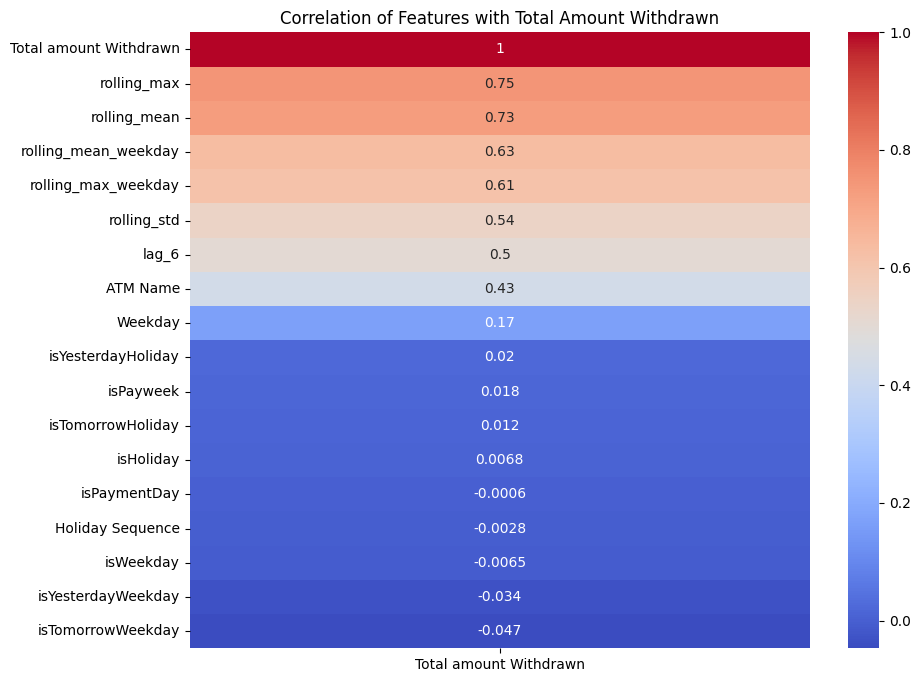

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

temp = data_encoded.drop(columns=['Transaction Date'])

# Calculate correlations
correlations = temp.corr()

# Display correlation with the target
plt.figure(figsize=(10, 8))
sns.heatmap(correlations[['Total amount Withdrawn']].sort_values(by='Total amount Withdrawn', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Total Amount Withdrawn')
plt.show()

In [42]:
# Check for low variance features
low_variance = temp.var().sort_values(ascending=True).head(10)
print("Low variance features:\n", low_variance)


Low variance features:
 isPaymentDay          6.289225e-02
isYesterdayHoliday    9.467620e-02
isTomorrowHoliday     9.586628e-02
isHoliday             9.596524e-02
isYesterdayWeekday    2.023702e-01
isWeekday             2.042770e-01
isTomorrowWeekday     2.055088e-01
isPayweek             2.441776e-01
Holiday Sequence      1.634455e+08
Weekday               3.317721e+09
dtype: float64


In [43]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# Use Ridge as the model for RFE
ridge = Ridge()

# Perform RFE to select top features
rfe = RFE(estimator=ridge, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get ranking of features
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
print("Feature rankings:\n", ranking)


Feature rankings:
 isWeekday               1
Weekday                 1
isYesterdayHoliday      1
isHoliday               1
isTomorrowHoliday       1
isYesterdayWeekday      1
isTomorrowWeekday       1
rolling_std             1
isPaymentDay            1
isPayweek               1
rolling_max             2
rolling_mean            3
Holiday Sequence        4
rolling_mean_weekday    5
ATM Name                6
lag_6                   7
rolling_max_weekday     8
dtype: int32


Mean Absolute Percentage Error (MAPE): 2.64%
Mean Absolute Error (MAE): 151629.46978868847
Mean Squared Error (MSE): 41263268707.65609
Root Mean Squared Error (RMSE): 203133.62278967036


C:\Users\edurz\AppData\Local\Temp\ipykernel_18280\2604087314.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


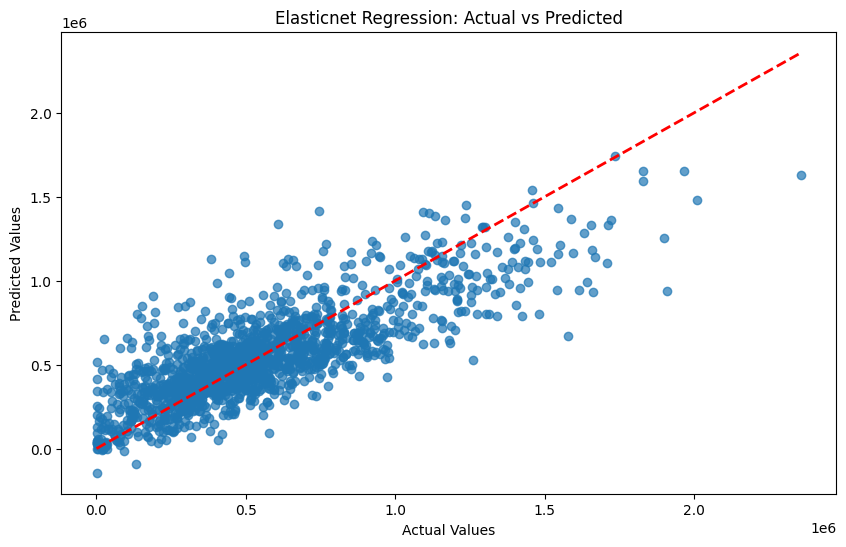

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Asumimos que los mejores parámetros se obtuvieron con Optuna:
# Mejor modelo y parámetros obtenidos de Optuna
best_params = study.best_params  # Obtenido de tu proceso de optimización con Optuna

# Seleccionar el modelo basado en los mejores parámetros
if best_params['model_type'] == 'ridge':
    model = Ridge(alpha=best_params['alpha'])
elif best_params['model_type'] == 'lasso':
    model = Lasso(alpha=best_params['alpha'])
else:  # ElasticNet
    model = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'])

# Entrenar el modelo con los mejores hiperparámetros
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MAPE, MAE, MSE y RMSE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Mostrar los resultados
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Gráfico de valores predichos vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'{best_params["model_type"].capitalize()} Regression: Actual vs Predicted')
plt.show()
